# Tests for significance of difference between 0TEK0503244655 scores and all others

In [1]:
import pymc as pm
import numpy as np
import pandas as pd

Load data into dataframe.

In [2]:
data = [
    {'tile': '10TEL0509245547', 'year': 2022, 'ROC AUC': 0.9714, 'Accuracy': 0.9315, 'Log Loss': 0.3583},
    {'tile': '10TDL0458245240', 'year': 2022, 'ROC AUC': 0.9953, 'Accuracy': 0.9836, 'Log Loss': 0.1878},
    {'tile': '10TEK0503244655', 'year': 2022, 'ROC AUC': 0.9156, 'Accuracy': 0.8444, 'Log Loss': 0.7774},
    {'tile': '10TDL0464245187', 'year': 2022, 'ROC AUC': 0.9959, 'Accuracy': 0.9858, 'Log Loss': 0.0598},
    {'tile': '10TDL0480045075', 'year': 2020, 'ROC AUC': 0.9833, 'Accuracy': 0.9976, 'Log Loss': 0.0499},
    {'tile': '10TDL0480045075', 'year': 2022, 'ROC AUC': 0.9977, 'Accuracy': 0.9820, 'Log Loss': 0.1009},
    {'tile': '10TDL0480045075', 'year': 2018, 'ROC AUC': None,  'Accuracy': 0.9451, 'Log Loss': None},
    {'tile': '10TEK0500244992', 'year': 2022, 'ROC AUC': 0.9996, 'Accuracy': 0.9887, 'Log Loss': 0.0503},
    {'tile': '10TDL0488245360', 'year': 2022, 'ROC AUC': 0.9990, 'Accuracy': 0.9859, 'Log Loss': 0.1460},
]

df = pd.DataFrame.from_dict(data)
df


,tile,year,ROC AUC,Accuracy,Log Loss
0,10TEL0509245547,2022,0.9714,0.9315,0.3583
1,10TDL0458245240,2022,0.9953,0.9836,0.1878
2,10TEK0503244655,2022,0.9156,0.8444,0.7774
3,10TDL0464245187,2022,0.9959,0.9858,0.0598
4,10TDL0480045075,2020,0.9833,0.9976,0.0499
5,10TDL0480045075,2022,0.9977,0.9820,0.1009
6,10TDL0480045075,2018,NaN,0.9451,NaN
7,10TEK0500244992,2022,0.9996,0.9887,0.0503
8,10TDL0488245360,2022,0.9990,0.9859,0.1460


Observe that the few pieces of data we have do not apear to be normally distributed.

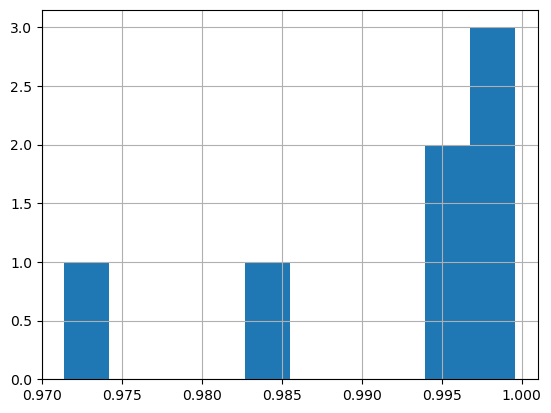

In [22]:
df[df.tile != '10TEK0503244655']['ROC AUC'].hist();

Get the ROC AUC values for all tiles other than 10TEK0503244655 (dropping 10TDL0480045075, since it is NA)

In [8]:
# ROC AUC data, excluding 10TEK0503244655
data_roc_auc = df[df.tile != '10TEK0503244655']['ROC AUC'].dropna().values
data_roc_auc

array([0.9714, 0.9953, 0.9959, 0.9833, 0.9977, 0.9996, 0.999 ])

Calculate Robust Z-Score.  If the absolute value of the score is much more than 1, one would think of the value as an outlier.

Huber, Peter J., and E. M. Ronchetti. _Robust statistics. 2nd john wiley & sons._ Hoboken, NJ 2 (2009).

In [9]:
data = data_roc_auc

#  Median Absolute Deviation (MAD)
median_value = np.median(data)
mad_value = np.median(np.abs(data - median_value))

# 10TEK0503244655 ROC AUC
target_value = 0.9156

#robust Z-score 
robust_z_score = 0.6745 * (target_value - median_value) / mad_value

print("Robust Z-score:", robust_z_score)

Robust Z-score: -17.47172580645167


The score strongly suggests it's an outlier!  The score for 10TEK0503244655 is more than 17 times the median absolute deviation (MAD) below the central tendency, as measured by the median.

Now let's do a Bayesian test (even though it is not normal, we will use a normal distribution in this case.  It is possible the distribution would be normal with more data, so we will test that case.)

In [10]:
# model
with pm.Model() as model:
    # Prior
    mu = pm.Uniform('mu', lower=0, upper=1)
    sigma = pm.HalfNormal('sigma', tau=1 / 0.1**2)
    
    # Likelihood
    observed = pm.Normal('observed', mu=mu, tau=1 / sigma**2, observed=data_roc_auc)
    
    # Posterior
    trace = pm.sample(5000, tune=1000)

# Now we can look at the posterior predictive distribution to see how likely 0.9184 is, given the data
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

roc_auc_values = posterior_predictive['observed_data']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.
/home/michael/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [observed]


In [21]:
draws = posterior_predictive['posterior_predictive'].observed.to_numpy().flatten()

f'Target is abs(target_value - draws.mean()) / draws.std() standard deviations from the mean!' 

5.028324067057073